## Pacotes Python Usados no Projeto

In [1]:
# Imports
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Configurações básicas para os gráficos
plt.rcParams['figure.figsize'] = [6, 5]

In [3]:
%reload_ext watermark
%watermark -a "Churn Aluno"

Author: Churn Aluno



## Carregando os Dados

In [4]:
# Carregando o dataset
df = pd.read_csv('student_churn_dataset.csv')

In [5]:
# Shape
df.shape

(1000, 7)

In [6]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Idade               1000 non-null   int64  
 1   HorasEstudoSemanal  1000 non-null   int64  
 2   TipoCurso           1000 non-null   object 
 3   SatisfacaoCurso     1000 non-null   int64  
 4   DuracaoCurso        1000 non-null   object 
 5   Mensalidade         1000 non-null   float64
 6   Churn               1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


In [7]:
# Amostra dos dados
df.head()

,Idade,HorasEstudoSemanal,TipoCurso,SatisfacaoCurso,DuracaoCurso,Mensalidade,Churn
0,56,52,Presencial,1,Semestral,75.48,0
1,69,65,Online,4,Semestral,79.25,0
2,46,76,Semi-Presencial,3,Anual,183.56,0
3,32,42,Online,2,Anual,162.50,0
4,60,74,Semi-Presencial,2,Anual,186.23,1


## Análise Exploratória

Definimos a variável target (alvo do estudo).

Variável Churn:

- 1 --> Classe positiva (houve churn, ou seja, cancelou a assinatura)
- 0 --> Classe negativa (não houve churn, ou seja, não cancelou a assinatura)

In [8]:
# Análise Exploratória de Dados (EDA)
def eda(dados):
    
    for column in dados.columns:
        
        # Se a coluna for numérica
        if dados[column].dtype in ['int64', 'float64']:
            
            # Histograma e Boxplot
            fig, axes = plt.subplots(1, 2)
            sns.histplot(dados[column], kde = True, ax = axes[0])
            sns.boxplot(x = 'Churn', y = column, data = dados, ax = axes[1])
            axes[0].set_title(f'Distribuição de {column}')
            axes[1].set_title(f'{column} vs Churn')
            plt.tight_layout()
            plt.show()
            
        # Se a coluna for categórica
        else:
            
            # Contagem de frequência e relação com Churn
            fig, axes = plt.subplots(1, 2)
            sns.countplot(x = column, data = dados, ax = axes[0])
            sns.countplot(x = column, hue = 'Churn', data = dados, ax = axes[1])
            axes[0].set_title(f'Distribuição de {column}')
            axes[1].set_title(f'{column} vs Churn')
            plt.tight_layout()
            plt.show()

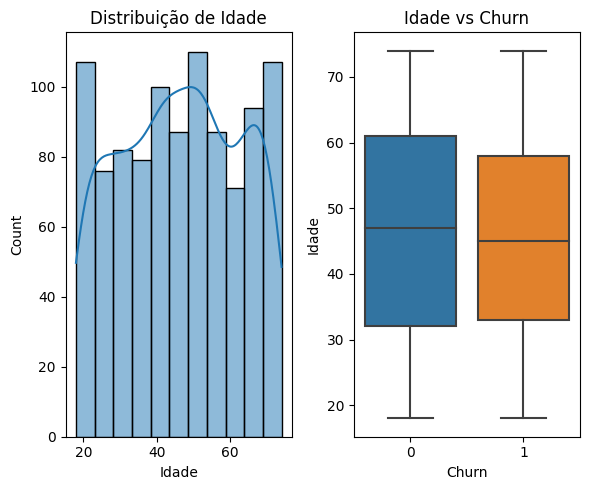

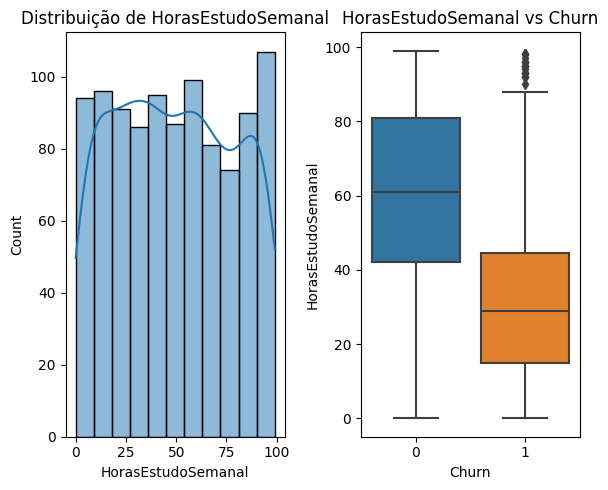

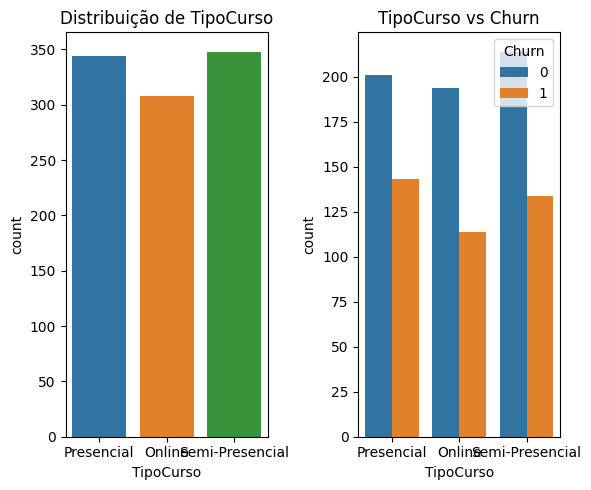

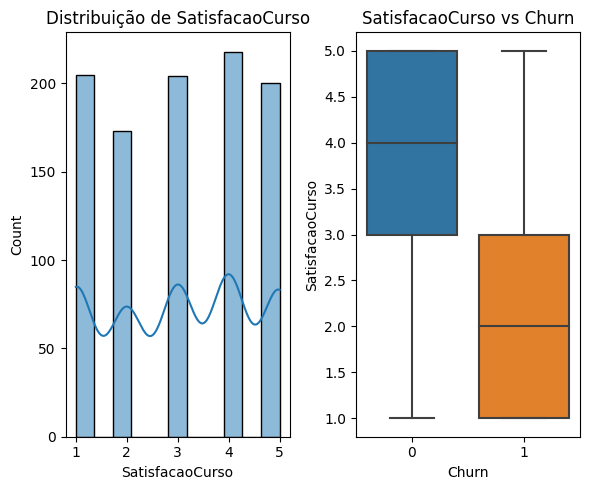

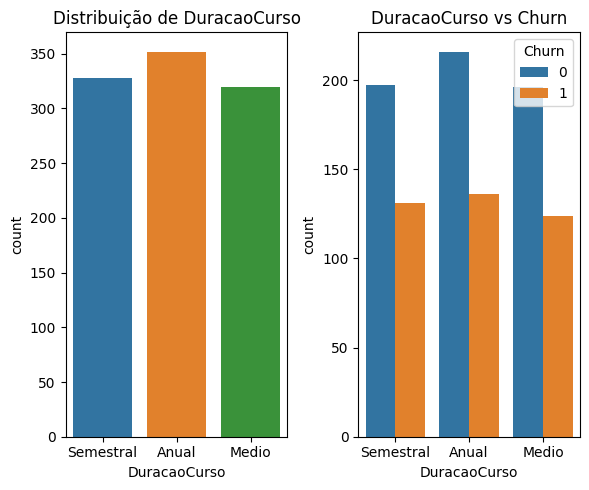

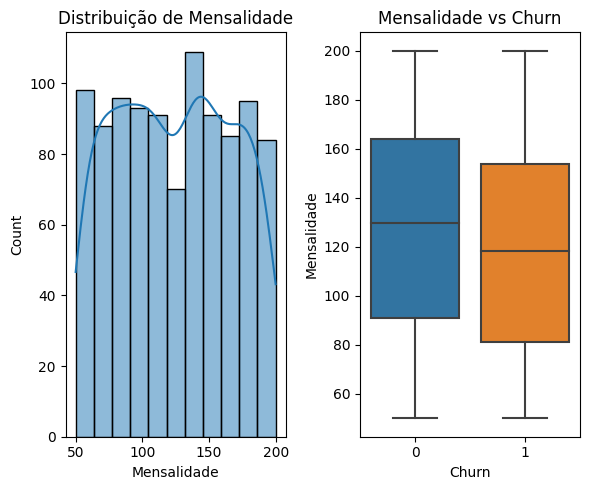

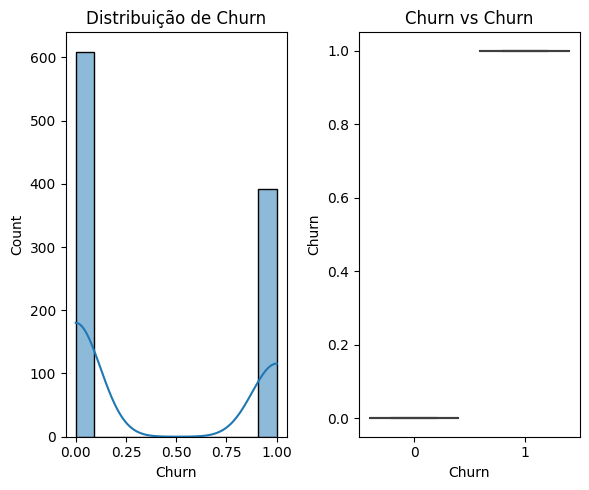

In [9]:
# Realizando a EDA
eda(df)

## Automação do Processo de Divisão em Dados de Treino e Teste

In [10]:
# Função para automatizar a divisão em treino e teste
def split_dataset(data, target_column, test_size, random_state = 42):
    """
    Divide o dataset em conjuntos de treino e teste.

    Parâmetros:
    - data (DataFrame): O DataFrame completo.
    - target_column (str): O nome da coluna alvo (target).
    - test_size (float): A proporção do conjunto de teste.
    - random_state (int): Seed para a geração de números aleatórios (padrão é 42).

    Retorna:
    - X_train (DataFrame): Conjunto de treino para as variáveis independentes.
    - X_test (DataFrame): Conjunto de teste para as variáveis independentes.
    - y_train (Series): Conjunto de treino para a variável alvo.
    - y_test (Series): Conjunto de teste para a variável alvo.
    """

    # Dados de entrada
    X = data.drop(target_column, axis = 1)
    
    # Dados de saída
    y = data[target_column]
    
    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = test_size, 
                                                        random_state = random_state)

    return X_train, X_test, y_train, y_test

In [11]:
# Uso da função anterior
valor_test_size = 0.3
X_train, X_test, y_train, y_test = split_dataset(df, 'Churn', test_size = valor_test_size)

In [12]:
# Verificando o tamanho dos conjuntos de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 6), (300, 6), (700,), (300,))

## Pré-Processamento dos Dados

O pré-processamento, especialmente a aplicação de técnicas de encoding e a normalização de dados, deve idealmente ser feito após a divisão do dataset em conjuntos de treino e teste. Isso evita o vazamento de informações do conjunto de teste para o conjunto de treino, o que pode acontecer se o pré-processamento for feito antes da divisão. 

In [13]:
# Amostra dos dados
df.head()

,Idade,HorasEstudoSemanal,TipoCurso,SatisfacaoCurso,DuracaoCurso,Mensalidade,Churn
0,56,52,Presencial,1,Semestral,75.48,0
1,69,65,Online,4,Semestral,79.25,0
2,46,76,Semi-Presencial,3,Anual,183.56,0
3,32,42,Online,2,Anual,162.50,0
4,60,74,Semi-Presencial,2,Anual,186.23,1


In [14]:
# Selecionando as variáveis categóricas
categorical_cols = df.select_dtypes(include = ['object']).columns

In [15]:
categorical_cols

Index(['TipoCurso', 'DuracaoCurso'], dtype='object')

### One-Hot Encoding

In [16]:
# Aplicando One-Hot Encoding separadamente aos conjuntos de treino e teste
encoder = OneHotEncoder(sparse_output = False)

Por padrão, o OneHotEncoder retorna uma matriz esparsa quando você o utiliza para transformar dados. Uma matriz esparsa é uma maneira eficiente de armazenar dados com muitos zeros (valores não presentes). No entanto, se você definir sparse_output=False, o encoder retornará uma matriz densa (numpy array) em vez de uma matriz esparsa. Uma matriz densa é mais fácil de trabalhar e entender, mas pode consumir mais memória se os dados forem grandes e a maioria dos valores for zero.

In [17]:
# Treinando o encoder com o conjunto de treino e transformando ambos treino e teste
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

In [18]:
# Renomeando as colunas para corresponderem aos nomes das categorias
X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

In [19]:
# Removendo as colunas categóricas originais e adicionando as codificadas
X_train_preprocessed = X_train.drop(categorical_cols, axis = 1).reset_index(drop = True)
X_train_preprocessed = pd.concat([X_train_preprocessed, X_train_encoded], axis = 1)

In [20]:
X_train_preprocessed.head()

,Idade,HorasEstudoSemanal,SatisfacaoCurso,Mensalidade,TipoCurso_Online,TipoCurso_Presencial,TipoCurso_Semi-Presencial,DuracaoCurso_Anual,DuracaoCurso_Medio,DuracaoCurso_Semestral
0,65,80,4,174.10,0.0,0.0,1.0,0.0,1.0,0.0
1,49,18,3,101.59,1.0,0.0,0.0,1.0,0.0,0.0
2,19,91,4,87.93,1.0,0.0,0.0,0.0,1.0,0.0
3,52,0,1,90.74,0.0,0.0,1.0,1.0,0.0,0.0
4,62,60,1,134.59,1.0,0.0,0.0,0.0,0.0,1.0


Toda e qualquer transformação aplicada aos dados de treino, deve ser aplicada aos dados de teste e aos novos dados.

In [21]:
# Removendo as colunas categóricas originais e adicionando as codificadas
X_test_preprocessed = X_test.drop(categorical_cols, axis = 1).reset_index(drop = True)
X_test_preprocessed = pd.concat([X_test_preprocessed, X_test_encoded], axis = 1)

In [22]:
# Visualizando as primeiras linhas dos datasets de treino e teste após pré-processamento
X_train_preprocessed.head()

,Idade,HorasEstudoSemanal,SatisfacaoCurso,Mensalidade,TipoCurso_Online,TipoCurso_Presencial,TipoCurso_Semi-Presencial,DuracaoCurso_Anual,DuracaoCurso_Medio,DuracaoCurso_Semestral
0,65,80,4,174.10,0.0,0.0,1.0,0.0,1.0,0.0
1,49,18,3,101.59,1.0,0.0,0.0,1.0,0.0,0.0
2,19,91,4,87.93,1.0,0.0,0.0,0.0,1.0,0.0
3,52,0,1,90.74,0.0,0.0,1.0,1.0,0.0,0.0
4,62,60,1,134.59,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
X_test_preprocessed.head()

,Idade,HorasEstudoSemanal,SatisfacaoCurso,Mensalidade,TipoCurso_Online,TipoCurso_Presencial,TipoCurso_Semi-Presencial,DuracaoCurso_Anual,DuracaoCurso_Medio,DuracaoCurso_Semestral
0,36,86,3,190.77,0.0,0.0,1.0,0.0,1.0,0.0
1,61,31,4,177.03,1.0,0.0,0.0,0.0,1.0,0.0
2,24,38,2,139.14,1.0,0.0,0.0,0.0,0.0,1.0
3,26,94,4,162.87,0.0,0.0,1.0,0.0,0.0,1.0
4,70,70,1,58.34,0.0,1.0,0.0,0.0,0.0,1.0


### StandardScaler

In [24]:
# Variáveis numéricas
numeric_cols = X_train_preprocessed.select_dtypes(include = ['int64', 'float64']).columns

In [25]:
# Criando o StandardScaler
scaler = StandardScaler()

In [26]:
# Aplicando o StandardScaler às variáveis numéricas
X_train_preprocessed[numeric_cols] = scaler.fit_transform(X_train_preprocessed[numeric_cols])
X_test_preprocessed[numeric_cols] = scaler.transform(X_test_preprocessed[numeric_cols])

In [27]:
# Visualizando as primeiras linhas dos datasets de treino e teste após pré-processamento
X_train_preprocessed.head()

,Idade,HorasEstudoSemanal,SatisfacaoCurso,Mensalidade,TipoCurso_Online,TipoCurso_Presencial,TipoCurso_Semi-Presencial,DuracaoCurso_Anual,DuracaoCurso_Medio,DuracaoCurso_Semestral
0,1.180292,1.069020,0.676895,1.130872,-0.668043,-0.720027,1.362770,-0.729197,1.415730,-0.685994
1,0.178225,-1.055509,-0.029255,-0.544723,1.496910,-0.720027,-0.733799,1.371371,-0.706349,-0.685994
2,-1.700652,1.445952,0.676895,-0.860385,1.496910,-0.720027,-0.733799,-0.729197,1.415730,-0.685994
3,0.366112,-1.672308,-1.441554,-0.795450,-0.668043,-0.720027,1.362770,1.371371,-0.706349,-0.685994
4,0.992405,0.383688,-1.441554,0.217856,1.496910,-0.720027,-0.733799,-0.729197,-0.706349,1.457738


In [28]:
X_test_preprocessed.head()

,Idade,HorasEstudoSemanal,SatisfacaoCurso,Mensalidade,TipoCurso_Online,TipoCurso_Presencial,TipoCurso_Semi-Presencial,DuracaoCurso_Anual,DuracaoCurso_Medio,DuracaoCurso_Semestral
0,-0.635955,1.274619,-0.029255,1.516090,-0.668043,-0.720027,1.362770,-0.729197,1.415730,-0.685994
1,0.929775,-0.610043,0.676895,1.198580,1.496910,-0.720027,-0.733799,-0.729197,1.415730,-0.685994
2,-1.387505,-0.370177,-0.735404,0.323000,1.496910,-0.720027,-0.733799,-0.729197,-0.706349,1.457738
3,-1.262247,1.548752,0.676895,0.871364,-0.668043,-0.720027,1.362770,-0.729197,-0.706349,1.457738
4,1.493438,0.726354,-1.441554,-1.544164,-0.668043,1.388838,-0.733799,-0.729197,-0.706349,1.457738


## Modelagem

In [29]:
# Criando o modelo RandomForest
modelo_v1 = RandomForestClassifier(random_state = 42)

In [30]:
# Treinando o modelo
modelo_v1.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Fazendo previsões no conjunto de teste
y_pred = modelo_v1.predict(X_test_preprocessed)

In [32]:
# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [33]:
accuracy

0.7866666666666666

In [34]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       182
           1       0.72      0.75      0.73       118

    accuracy                           0.79       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.79      0.79       300



## Validação Cruzada

In [35]:
# Criando um novo modelo RandomForest para validação cruzada
modelo_cv = RandomForestClassifier(random_state = 42)

In [36]:
# Realizando a validação cruzada
# Usaremos 5 folds para a validação cruzada
cv_scores = cross_val_score(modelo_cv, X_train_preprocessed, y_train, cv = 5)

In [37]:
cv_scores

array([0.78571429, 0.78571429, 0.77142857, 0.72857143, 0.69285714])

Estes resultados fornecem uma visão mais robusta do desempenho do modelo, pois a validação cruzada avalia a capacidade do modelo de generalizar para novos dados. A variação nas pontuações de acurácia entre os diferentes folds indica que o modelo pode se comportar de maneira inconsistente em diferentes subconjuntos dos dados. Isso pode ser devido a características dos dados, como desbalanceamento de classes, ou à necessidade de um ajuste mais fino dos hiperparâmetros do modelo.

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Otimização de Hiperparâmetros

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [38]:
# Definindo os hiperparâmetros para serem otimizados
param_grid = {
    'n_estimators': [50, 100, 200],   # Número de árvores
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 4, 6],   # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]     # Número mínimo de amostras exigido em um nó folha
}

In [39]:
# Criando o modelo RandomForest para a otimização
modelo_opt = RandomForestClassifier(random_state = 42)

In [40]:
# Configurando a busca em grade com validação cruzada
grid_search = GridSearchCV(modelo_opt, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)

In [41]:
# Realizando a otimização com o conjunto de treino
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [42]:
# Melhores parâmetros e pontuação
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [43]:
best_params, best_score

({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.7642857142857143)

## Versão Final do Modelo

In [44]:
# Criando o modelo RandomForest com os melhores hiperparâmetros
modelo_RF_final = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                                          max_depth = best_params['max_depth'],
                                          min_samples_split = best_params['min_samples_split'],
                                          min_samples_leaf = best_params['min_samples_leaf'],
                                          random_state = 42)

In [45]:
# Treinando o modelo final com o conjunto de treino
modelo_RF_final.fit(X_train_preprocessed, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [46]:
# Previsões com dados de teste
y_pred_final = modelo_RF_final.predict(X_test_preprocessed)

In [47]:
# Avaliando o modelo final no conjunto de teste
final_accuracy = accuracy_score(y_test, y_pred_final)
final_classification_report = classification_report(y_test, y_pred_final)

In [48]:
final_accuracy

0.7933333333333333

In [49]:
print(final_classification_report)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       182
           1       0.73      0.75      0.74       118

    accuracy                           0.79       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.79      0.79       300



## Mas e a probabilidade das classes?

Alguns modelos podem ser confiáveis no processo de classificação, mas as probabilidades associadas às suas previsões podem ser enganosas. Por isso devemos medir a calibração do nosso modelo.



In [50]:
y_prob = modelo_RF_final.predict_proba(X_test_preprocessed)[:, 1]


## CalibrationCurve

Avaliar a calibração das probabilidades do modelo. Esta função retorna dois resultados principais: 
- a fração de positivos 
- média das probabilidades previstas. 

Com estas duas informações vamos desenhar o Calibration Plot. Adicionalmente, podemos inserir uma linha tracejada para indicar o que seria a calibração perfeita.

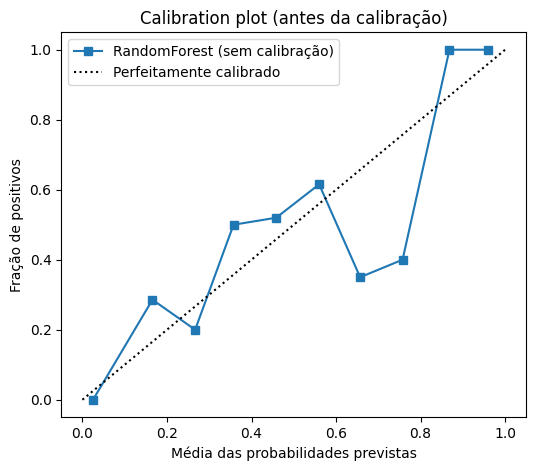

In [64]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Calculando o calibration curve
fracao_positivos, media_prob_previstas = calibration_curve(y_test, y_prob, n_bins=10)

# Plotando o Calibration Plot
plt.plot(media_prob_previstas, fracao_positivos, "s-", label="RandomForest (sem calibração)")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")  
plt.xlabel("Média das probabilidades previstas")
plt.ylabel("Fração de positivos")
plt.title('Calibration plot (antes da calibração)')
plt.legend()
plt.show()

### Análise do Calibration Plot (antes da calibração)


1. **Curva de Calibração (Azul)**: A linha azul mostra o desempenho do modelo Random Forest antes da calibração. Ela representa a relação entre a média das probabilidades previstas e a fração de positivos (ou seja, a proporção de amostras positivas dentro de cada intervalo de previsão de probabilidade).

2. **Curva Ideal (Linha Pontilhada)**: A linha preta pontilhada indica uma calibração perfeita. Um modelo perfeitamente calibrado teria todas as suas previsões próximas dessa linha, onde as probabilidades previstas correspondem exatamente à fração real de positivos. 

3. **Interpretação dos Resultados**:
   - Quando a curva do modelo está **abaixo** da linha pontilhada, significa que o modelo está **subestimando** as probabilidades; ou seja, ele prevê uma probabilidade menor do que a real.
   - Quando a curva está **acima** da linha pontilhada, o modelo está **superestimando** as probabilidades, prevendo uma probabilidade maior do que a verdadeira taxa de positivos.

4. **Desempenho do Modelo**:
   - A curva mostra que o modelo Random Forest não está perfeitamente calibrado, com variações significativas ao longo do intervalo de probabilidades. Em algumas regiões, o modelo superestima (valores acima da linha pontilhada) e, em outras, subestima (valores abaixo da linha).
   - Isso sugere que o modelo pode se beneficiar de uma **calibração** (como Platt Scaling ou Isotonic Regression) para ajustar melhor suas previsões de probabilidade.

5. **Impacto para Modelos de Churn**:
   - Em um contexto de previsão de churn, um modelo calibrado corretamente é crucial, pois previsões de probabilidade bem ajustadas ajudam a tomar melhores decisões de negócio. Por exemplo, prever com alta confiança quais clientes estão em risco de churn permite ações mais precisas e econômicas.


Esse calibration plot indica que o modelo Random Forest, sem calibração, apresenta inconsistências nas previsões de probabilidade. Ajustar esse modelo com técnicas de calibração pode melhorar a precisão das probabilidades previstas, o que é especialmente importante em contextos de negócio como churn, onde decisões baseadas em previsões confiáveis são críticas para estratégias de retenção.

---

## Calibrando o modelo com Platt Scaling

O método de calibração de probabilidades Platt Scaling utiliza, basicamente, uma função sigmoide para ajustar as previsões.


$$
p(x) = \frac{1}{1 + e^{A f(x) + B}}
$$

Na qual:

- \( f(x) \) é a probabilidade não calibrada
- \( A \) e \( B \) são parâmetros ajustados no treinamento do Platt Scaling
- \( p(x) \) é a probabilidade calibrada


É como se este método estivesse ajustando uma regressão logística às probabilidades originais, encontrando os valores de A e B que minimizem a Log-Loss (mais para frente falaremos dela).

É uma abordagem rápida, funciona para diferentes modelos e eficiente, principalmente para pequenos conjuntos de dados. Em compensação, não é uma técnica tão flexível, já que **assume uma relação sigmoidal (curva em formato de “S”) entre as probabilidades não calibradas e as calibradas**, o que nem sempre pode ser verdade.

De modo geral, podemos utilizar este método através da classe CalibratedClassifier, definindo method=’sigmoid’. O parâmetro cv está relacionado ao número de folds da validação cruzada. Porém, **caso já tenhamos treinado o modelo (nossa situação neste exemplo), então devemos definir cv=’prefit’**.

In [52]:
calibrated_RF_sigmoid = CalibratedClassifierCV(modelo_RF_final, method='sigmoid', cv='prefit') 
calibrated_RF_sigmoid.fit(X_test_preprocessed, y_test)

# Prevendo probabilidades no conjunto de teste após a calibração
y_prob_sigmoid = calibrated_RF_sigmoid.predict_proba(X_test_preprocessed)[:, 1]

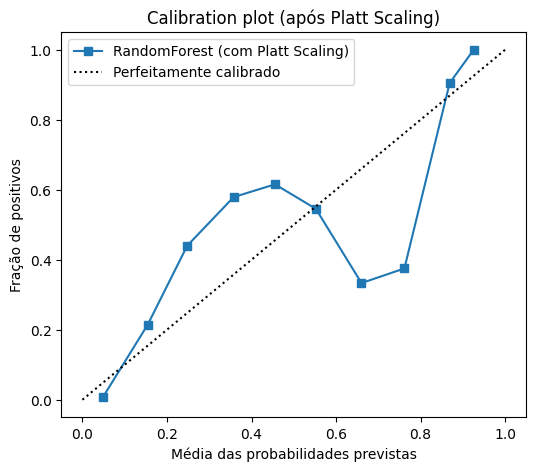

In [53]:
# Calculando o calibration curve
fracao_positivos_sigmoid, media_prob_previstas_sigmoid = calibration_curve(y_test, y_prob_sigmoid, n_bins=10)

# Plotando o Calibration Plot após a calibração
plt.plot(media_prob_previstas_sigmoid, fracao_positivos_sigmoid, "s-", label="RandomForest (com Platt Scaling)")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")  # Linha de calibração perfeita
plt.xlabel("Média das probabilidades previstas")
plt.ylabel("Fração de positivos")
plt.title('Calibration plot (após Platt Scaling)')
plt.legend()
plt.show()

### Análise do Calibration Plot do Random Forest (após Platt Scaling)


1. **Interpretação dos Resultados**:
   - Após a aplicação do Platt Scaling, observa-se que a curva de calibração se aproxima melhor da linha de calibração perfeita, especialmente para probabilidades próximas de 0 e 1.
   - Ainda há pequenas oscilações em torno da linha ideal, especialmente entre as regiões de 0.4 e 0.8, indicando que, embora o modelo esteja mais calibrado, ele ainda pode subestimar ou superestimar em alguns intervalos.

2. **Impacto da Calibração para Modelos de Churn**:
   - A calibração por Platt Scaling melhora a confiança nas previsões de probabilidade, que é essencial para modelos de churn. Com probabilidades calibradas, o modelo permite uma avaliação mais precisa do risco de evasão de clientes, possibilitando decisões de retenção mais assertivas e focadas.

3. **Conclusão**:
   - A aplicação do Platt Scaling melhorou a calibração das previsões do modelo Random Forest, aproximando-o da curva ideal. Embora ainda existam algumas pequenas discrepâncias, o modelo apresenta agora uma calibração mais adequada para a tomada de decisões baseadas em probabilidades.
   - Em contextos onde previsões de probabilidade precisas são críticas, como na retenção de clientes, essa calibração pode fazer a diferença entre ações preventivas efetivas e decisões menos precisas.

---


## Calibrando o modelo com Isotonic Regression

Neste método não nos é imposto uma forma fixa (é não paramétrico), como a sigmoidal no caso do Platt Scaling. Aqui o objetivo é encontrar as novas probabilidades de tal forma a **minimizar a soma dos quadrados da diferença entre o rótulo original (0 ou 1) e a probabilidade calibrada.**

$$
\min \sum_{i=1}^{n} (y_i - \hat{p}_i)^2 \quad \text{sujeito a} \quad \hat{p}_1 \leq \hat{p}_2 \leq \cdots \leq \hat{p}_n
$$

Na qual:

- \( \hat{p}_i \) são as probabilidades calibradas
- \( y_i \) são os rótulos verdadeiros


Além disso, este método tem uma característica interessante já que é Monotonicamente crescente, ou seja, à medida em que os valores das probabilidades não calibradas vão aumentando, as probabilidades calibradas vão sempre aumentar ou permanecer constante, mas nunca decrescer.

Porém, por ser mais flexível, o Isotonic Regression pode acabar agrupando previsões que tenham valores muito próximos (várias previsões diferentes com o mesmo valor de probabilidade), criando empates entre os valores.

In [54]:
# Calibrando o modelo com Isotonic Regression
calibrated_RF_isotonic = CalibratedClassifierCV(modelo_RF_final, method='isotonic', cv='prefit')
calibrated_RF_isotonic.fit(X_test_preprocessed, y_test)

# Prevendo probabilidades no conjunto de teste após a calibração
y_prob_isotonic = calibrated_RF_isotonic.predict_proba(X_test_preprocessed)[:, 1]

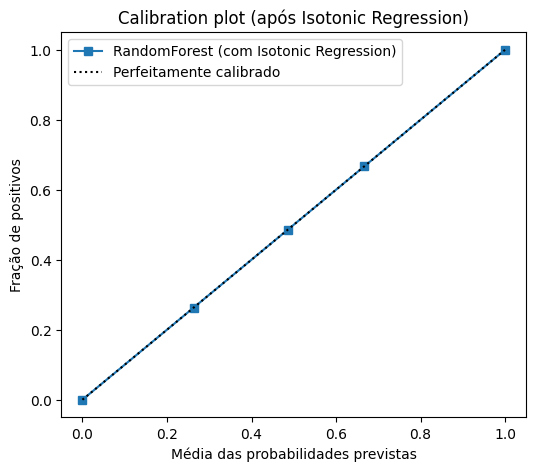

In [55]:
# Calculando o calibration curve
fracao_positivos_isotonic, media_prob_previstas_isotonic = calibration_curve(y_test, y_prob_isotonic, n_bins=10)

# Plotando o Calibration Plot após a calibração
plt.plot(media_prob_previstas_isotonic, fracao_positivos_isotonic, "s-", label="RandomForest (com Isotonic Regression)")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")  # Linha de calibração perfeita
plt.xlabel("Média das probabilidades previstas")
plt.ylabel("Fração de positivos")
plt.title('Calibration plot (após Isotonic Regression)')
plt.legend()
plt.show()

### Análise do Calibration Plot do Random Forest (após Isotonic Regression)


1. **Interpretação dos Resultados**:
   - A Isotonic Regression ajustou a curva de calibração para se alinhar quase exatamente com a linha de calibração perfeita.
   - Essa calibração indica que o modelo agora fornece previsões de probabilidade que refletem precisamente a realidade observada, sem superestimar ou subestimar as probabilidades em nenhuma faixa.

2. **Impacto da Calibração para Modelos de Churn**:
   - Para modelos de churn, uma calibração precisa permite uma avaliação mais confiável do risco de evasão de clientes, ajudando a equipe de retenção a tomar decisões baseadas em previsões de alta confiança.
   - Com a calibração ajustada pela Isotonic Regression, o modelo fornece probabilidades bem alinhadas com a realidade, o que é ideal para contextos onde é importante entender a verdadeira chance de churn de cada cliente.

3. **Conclusão**:
   - A aplicação da Isotonic Regression foi extremamente eficaz para calibrar o modelo Random Forest, proporcionando uma correspondência quase perfeita com a linha de calibração ideal.
   - Esse ajuste é particularmente valioso para modelos que necessitam de alta precisão nas probabilidades previstas, como no caso de previsão de churn, onde decisões de negócio são baseadas em avaliações de risco.



In [56]:
joblib.dump(calibrated_RF_isotonic, 'calibrated_RF_isotonic.pkl')

['calibrated_RF_isotonic.pkl']

In [57]:
joblib.dump(scaler, 'padronizador.pkl')

['padronizador.pkl']

## Métricas de avaliação: Brier Score & Log Loss


* **Brier Score**: Média dos erros quadráticos entre as probabilidades previstas e os valores reais (0 ou 1), representada pela seguinte expressão:

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} (p_i - o_i)^2
$$

Na qual:

- \( N \) é o tamanho do conjunto de dados
- \( o_i \) é o rótulo da amostra \( i \) (0 ou 1)
- \( p_i \) é a probabilidade prevista pelo modelo de que a amostra \( i \) pertence à classe 1


De acordo com a expressão acima, o Brier Score será sempre um valor entre 0 e 1. Se a previsão do modelo for perfeita, p_i = o_i para todas as amostras, então a métrica será 0. Caso contrário, quanto mais distantes estiverem as probabilidades dos rótulos reais, maior será o valor. Além disso, para classificação binária, um Brier Score de 0.5 indica uma atuação aleatória, um modelo que não sabe diferenciar entre 0s e 1s.


* **Log-Loss**: Avalia as diferenças entre as probabilidades previstas e os rótulos reais. Mas aqui temos um plus, a expressão penaliza os erros de forma logarítmica.

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(p_i) + (1 - y_i) \log(1 - p_i)\right]
$$

Na qual:

- \( N \) é o tamanho do conjunto de dados
- \( y_i \) é o rótulo da amostra \( i \) (0 ou 1)
- \( p_i \) é a probabilidade prevista pelo modelo de que a amostra \( i \) pertence à classe 1



Enquanto no Brier Score a penalização é sempre de forma quadrática, na Log-Loss, diferenças maiores entre a probabilidade e o rótulo são penalizadas de forma mais agressiva. É isso que faz essa métrica tão importante em machine learning.

Aqui também o intervalo da métrica vai de 0 (melhor cenário) a 1 (pior cenário). Se o modelo costuma fazer previsões corretas e confiantes (probs perto de 0 para classe 0 e probs perto de 1 para a classe 1) o valor da Log-Loss será baixo. Caso o modelo faça previsões erradas ou menos confiantes, o valor aumentará. Por exemplo, prever 99% de chance quando o rótulo real é 0, isso é um erro gravíssimo.

In [58]:
from sklearn.metrics import brier_score_loss, log_loss

# Brier score antes da calibração
brier_before = brier_score_loss(y_test, y_prob)
print(f"Brier score antes da calibração: {brier_before:.4f}")

# Brier score após Platt Scaling
brier_sigmoid = brier_score_loss(y_test, y_prob_sigmoid)
print(f"Brier score após Platt Scaling: {brier_sigmoid:.4f}")

# Brier score após Isotonic Regression
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier score após Isotonic Regression: {brier_isotonic:.4f}")

Brier score antes da calibração: 0.1196
Brier score após Platt Scaling: 0.1274
Brier score após Isotonic Regression: 0.1036


* Brier Score Antes da Calibração: 0.1196

    - Este valor representa o Brier Score do modelo original, antes de qualquer calibração. Ele serve como uma linha de base para comparação. Quanto menor o Brier Score, melhor calibrado está o modelo.

* Brier Score Após Platt Scaling: 0.1274

    - O Brier Score aumentou ligeiramente após a calibração com Platt Scaling, passando de 0.1196 para 0.1274. Isso indica que o Platt Scaling não foi eficaz para melhorar a calibração do modelo neste caso; na verdade, ele piorou um pouco a calibração das probabilidades. Essa técnica pode não ter sido a mais adequada para o tipo de distribuições probabilísticas deste modelo.

* Brier Score Após Isotonic Regression: 0.1036

    - O Brier Score diminuiu significativamente após a calibração com Isotonic Regression, passando para 0.1036. Esse é o menor valor entre as três versões, indicando que Isotonic Regression foi a técnica de calibração mais eficaz neste caso.
    - A redução no Brier Score sugere que Isotonic Regression ajustou melhor as previsões probabilísticas, tornando-as mais alinhadas com as probabilidades reais observadas.

In [59]:
# Log Loss antes da calibração
logloss_before = log_loss(y_test, y_prob)
print(f"Log Loss antes da calibração: {logloss_before:.4f}")

# Log Loss após Platt Scaling
logloss_sigmoid = log_loss(y_test, y_prob_sigmoid)
print(f"Log Loss após Platt Scaling: {logloss_sigmoid:.4f}")

# Log Loss após Isotonic Regression
logloss_isotonic = log_loss(y_test, y_prob_isotonic)
print(f"Log Loss após Isotonic Regression: {logloss_isotonic:.4f}")

Log Loss antes da calibração: 0.3459
Log Loss após Platt Scaling: 0.3765
Log Loss após Isotonic Regression: 0.2899


* Log Loss Antes da Calibração: 0.3459

    - Este valor representa o Log Loss do modelo original, antes de qualquer calibração. O Log Loss mede a qualidade das previsões probabilísticas do modelo; quanto menor o valor, melhor a calibração das probabilidades.
    - Esse valor serve como referência para avaliar o impacto das técnicas de calibração.

* Log Loss Após Platt Scaling: 0.3765

    - O Log Loss aumentou após a aplicação do Platt Scaling, passando de 0.3459 para 0.3765. Esse aumento indica que o Platt Scaling não melhorou a calibração das previsões e até piorou a qualidade das probabilidades previstas.
    - Isso sugere que o Platt Scaling não foi adequado para este modelo em específico, talvez devido à natureza das distribuições probabilísticas, que podem não ter se beneficiado da transformação sigmoidal aplicada pelo Platt Scaling.

* Log Loss Após Isotonic Regression: 0.2899

    - O Log Loss diminuiu significativamente após a aplicação da Isotonic Regression, alcançando 0.2899. Este é o menor valor entre os três cenários (sem calibração, com Platt Scaling e com Isotonic Regression).
    - Essa redução no Log Loss indica que a Isotonic Regression melhorou a calibração das probabilidades previstas pelo modelo, tornando-as mais precisas e bem ajustadas à realidade dos dados.

In [60]:
%watermark -a "Churn Aluno"

Author: Churn Aluno



In [61]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.29.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [62]:
%watermark --iversions

joblib    : 1.2.0
pandas    : 2.0.3
numpy     : 1.24.3
matplotlib: 3.7.2
sklearn   : 1.3.0
seaborn   : 0.12.2

